# HW4. Indexes & Query Processing & Normalization

## Objectives

In this assignment, you will review what you have learned in the Normalization, Views and Indexes, and Query Processing Modules. In particular, you will practice:

- How indexing can change query processing
- How indexing changes query performance
- How B-Trees store records
- Query processing and optimization
- How to construct BCNF and 3NF decomposition

## Q1 (10 points): Indexing

In this question, you will be asked to select suitable indexes to speed up query performance and examine the query plan of a SQL query.

We are going to use a new database called flights.db. In the database, there is a single table, called FLIGHTS. The following shows its schema:

    FLIGHTS(fid, year, month_id, day_of_month, day_of_week_id, 
            carrier_id, flight_num, origin_city, origin_state, 
            dest_city, dest_state, departure_delay, taxi_out, 
            arrival_delay, canceled, actual_time, distance)

Note that this task only needs to use four attributes: `carrier_id`, `origin_city`, `actual_time`, and `dest_city`.

In [2]:
%load_ext sql

In [3]:
%sql sqlite:///flight.db

Consider the following queries:

```sqlite
(a)  SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Seattle WA' AND actual_time <= 180;
```


```sqlite
(b)  SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;
```


```sqlite
(c)  SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Seattle WA' AND actual_time <= 30;
```

Choose one single simple index (index on one attribute) that is most likely to speed up all three queries. Write down the `CREATE INDEX` statement and explain why you chose that index below.

Q1.1. (1 point) What is the CREATE INDEX statement?

In [3]:
%%sql
CREATE INDEX origin_time_index
ON Flights (origin_city, actual_time);



 * sqlite:///flight.db
(sqlite3.OperationalError) index origin_time_index already exists
[SQL: CREATE INDEX origin_time_index
ON Flights (origin_city, actual_time);]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


Q1.2. (1 point) Why did you choose the index? 

I choose orgin_city, actual_time because in 3 queries, they all select data based on the orgin city and the actual_time

Open a command line shell and start the sqlite program. Connect to the provided flights.db, and check whether the FLIGHTS table has the index that you indicate above. If not, add this index to the FLIGHTS table. 

Q1.3. (0.5 point) Does the FLIGHTS table has the index that you indicate above?

In [8]:
%%sql
SELECT *
FROM Flights;


 * sqlite:///flight.db
Done.


Q1.4. (1.5 point) Please check whether each query used the index or not. 

**Hint:** you can use `EXPLAIN QUERY PLAN` to see the query plan of each query. Indicate for each query if it used the index or not. 

In [9]:
%%sql
EXPLAIN QUERY PLAN
SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Seattle WA' AND actual_time <= 180;

 * sqlite:///flight.db
Done.


[(4, 0, 0, 'SEARCH Flights USING INDEX origin_time_index (origin_city=? AND actual_time<?)'),
 (17, 0, 0, 'USE TEMP B-TREE FOR DISTINCT')]

In [13]:
 %%sql
EXPLAIN QUERY PLAN
    SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;

 * sqlite:///flight.db
Done.


[(4, 0, 0, 'SEARCH Flights USING INDEX origin_time_index (origin_city=? AND actual_time<?)'),
 (17, 0, 0, 'USE TEMP B-TREE FOR DISTINCT')]

In [14]:
%%sql
EXPLAIN QUERY PLAN    
 SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Seattle WA' AND actual_time <= 30;

 * sqlite:///flight.db
Done.


[(4, 0, 0, 'SEARCH Flights USING INDEX origin_time_index (origin_city=? AND actual_time<?)'),
 (17, 0, 0, 'USE TEMP B-TREE FOR DISTINCT')]

Now, consider this query:

```sqlite
(d) SELECT DISTINCT F2.origin_city
     FROM Flights F1, Flights F2
     WHERE F1.dest_city = F2.dest_city
         AND F1.origin_city='Gunnison CO'
         AND F1.actual_time <= 30;
```

Q1.5. (2 points) Choose one simple index (index on one attribute), different from the index for the question above, that is likely to speed up this query. Write down the `CREATE INDEX` statement.

In [15]:
%%sql
CREATE INDEX origin_city
ON Flights (origin_city);


 * sqlite:///flight.db
Done.


[]

Check whether the FLIGHTS table has this second index that you indicate above. If not, add this index to the FLIGHTS table. 

Now we want to know how effective the two indexes are. We compare the runtimes of the queries with and without indexes. 

**Hint:** Use `timer on` on sqlite3 command line to turn SQL timer on.

Q1.6. (2 points) Execute queries (a) to (d) on the FLIGHTS table that do not have the two indexes. Please record the runtime of each query. 

In [18]:
%sql sqlite:///flight.db

In [52]:
#Drop the index for the purpose of timing the execution of queries withouut using index

In [48]:
%%sql
DROP INDEX origin_city

 * sqlite:///flight.db
Done.


[]

In [49]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('flight.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

#Query a
start_time_a = time.time()

cursor.execute("""SELECT DISTINCT carrier_id 
FROM Flights
WHERE origin_city = 'Seattle WA' AND actual_time <= 180""")

end_time_a = time.time()
execution_time_a = end_time_a - start_time_a
print("Execution time for queries a:", execution_time, "seconds")


#Query b
start_time_b = time.time()

cursor.execute("""SELECT DISTINCT carrier_id
FROM Flights
WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;""")

end_time_b = time.time()
execution_time_b = end_time_b - start_time_b
print("Execution time for queries b:", execution_time_b, "seconds")


#Query c
start_time_c = time.time()

cursor.execute("""SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 30;""")

end_time_c = time.time()
execution_time_c = end_time_c - start_time_c
print("Execution time for queries c:", execution_time_c, "seconds")


#Query d
start_time_d = time.time()

cursor.execute("""SELECT DISTINCT F2.origin_city 
FROM Flights F1, Flights F2
WHERE F1.dest_city = F2.dest_city 
AND F1.origin_city='Gunnison CO' 
AND F1.actual_time <= 30;""")

end_time_d = time.time()
execution_time_d = end_time_d - start_time_d
print("Execution time for queries d:", execution_time_d, "seconds")



# Close the cursor and connection
cursor.close()
conn.close()


Execution time for queries a: 0.002029895782470703 seconds
Execution time for queries b: 0.0009913444519042969 seconds
Execution time for queries c: 0.0010013580322265625 seconds
Execution time for queries d: 1.078381061553955 seconds


Q1.7. (2 points) Execute queries (a) to (d) on the FLIGHTS table that has the two indexes. Please record the runtime of each query. 

In [ ]:
#Create the index for timing the execution on qeuries using index

In [46]:
%%sql
CREATE INDEX origin_city
ON Flights (origin_city);

 * sqlite:///flight.db
(sqlite3.OperationalError) index origin_city already exists
[SQL: CREATE INDEX origin_city
ON Flights (origin_city);]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [47]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('flight.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

#Query a
start_time_a = time.time()

cursor.execute("""SELECT DISTINCT carrier_id 
FROM Flights
WHERE origin_city = 'Seattle WA' AND actual_time <= 180""")

end_time_a = time.time()
execution_time_a = end_time_a - start_time_a
print("Execution time for queries a:", execution_time, "seconds")


#Query b
start_time_b = time.time()

cursor.execute("""SELECT DISTINCT carrier_id
FROM Flights
WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;""")

end_time_b = time.time()
execution_time_b = end_time_b - start_time_b
print("Execution time for queries b:", execution_time_b, "seconds")


#Query c
start_time_c = time.time()

cursor.execute("""SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 30;""")

end_time_c = time.time()
execution_time_c = end_time_c - start_time_c
print("Execution time for queries c:", execution_time_c, "seconds")


#Query d
start_time_d = time.time()

cursor.execute("""SELECT DISTINCT F2.origin_city 
FROM Flights F1, Flights F2
WHERE F1.dest_city = F2.dest_city 
AND F1.origin_city='Gunnison CO' 
AND F1.actual_time <= 30;""")

end_time_d = time.time()
execution_time_d = end_time_d - start_time_d
print("Execution time for queries d:", execution_time_d, "seconds")



# Close the cursor and connection
cursor.close()
conn.close()

Execution time for queries a: 0.002029895782470703 seconds
Execution time for queries b: 0.001094818115234375 seconds
Execution time for queries c: 0.0009279251098632812 seconds
Execution time for queries d: 1.0014619827270508 seconds


## Q2 (6 points): B-Trees

Assume:

    (1) blocks can hold either 10 records or 99 keys and 100 pointers
    (2) the average B-tree node is 70% full. This means it will have 69 keys and 70 pointers. 

We can use B-trees as part of several different structures. For each structure described in the questions Q2.1 to Q2.3 below, determine: 

    (a) the total number of blocks needed for a 1,000,000-record file
    (b) the average number of disk I/O’s to retrieve a record given its search key

You may assume nothing is in memory initially, and the search key is the primary key for the records.

Q2.1. (2 points) The data file is a sequential file, sorted on the search key, with 10 records per block. The B-tree is a dense index.

(a) 
Lowest level: 1 000 000 / 10 = 100 000 blocks.
Leaf level: 1 000 000 / 70 = 14 286 blocks.
Third level: 14 286 / 70 = 204 blocks.
Second level: 204 / 70 =3 blocks.
The root level: 3 / 70 =1 blocks.
Total blocks can hold: 100 000 + 14 286 + 204 + 3 + 1 = 114 495 blocks

(b) Average number of disk I/O's = 5

Q2.2. (2 points) The data file is a sequential file, sorted on the search key, with 10 records per block. The B-tree is a sparse index.

(a) 
Lowest level: 1 000 000 / 10 = 100 000 blocks.
Leaf level: 100 000 / 70 = 1429 blocks.
Second level: 1429 / 70 = 21 blocks.
The root level: 21 / 70 =1 blocks.

Total blocks can hold: 100 000 + 1429 + 21 + 1 = 101 451 blocks

(b) Average number of disk I/O's = 4

Q2.3. (2 points) The data file consists of records in no particular order, packed 10 to a block. The B-tree is a dense index.

(a) 
Lowest level: 1 000 000 / 10 = 100 000 blocks.
Leaf level: 100 000 / 70 = 1429 blocks.
Second level: 1429 / 70 = 21 blocks.
The root level: 21 / 70 =1 blocks.

Total blocks can hold: 100 000 + 1429 + 21 + 1 = 101 451 blocks

(b) Average number of disk I/O's = 4

## Q3 (9 points): Query Processing

In the first assignment, given the bank database below:

 - Customer = {<span style="text-decoration:underline">customerID</span>, firstName, lastName, income, birthDate}
 - Account = {<span style="text-decoration:underline">accNumber</span>, type, balance, branchNumber<sup>FK-Branch</sup>}
 - Owns = {<span style="text-decoration:underline">customerID</span><sup>FK-Customer</sup>, <span style="text-decoration:underline">accNumber</span><sup>FK-Account</sup>}
 - Transactions = {<span style="text-decoration:underline">transNumber</span>, <span style="text-decoration:underline">accNumber</span><sup>FK-Account</sup>, amount}
 - Employee = {<span style="text-decoration:underline">sin</span>, firstName, lastName, salary, branchNumber<sup>FK-Branch</sup>}
 - Branch = {<span style="text-decoration:underline">branchNumber</span>, branchName, managerSIN<sup>FK-Employee</sup>, budget}

you wrote a SQL query to:

Show account number, account type, account balance, and transaction amount of the accounts with balance higher than 100,000 and transaction amounts higher than 15000, starting with the accounts with the highest transaction amount and highest account balance. 

Q3.1. (3 points) Parse your query into a query parse tree.

#PROVIDE YOUR ANSWER HERE. 

##You may provide an image containing your answers for this question. 

##See https://mljar.com/blog/jupyter-notebook-insert-image/ for ways to insert images in Jupyter Notebook.

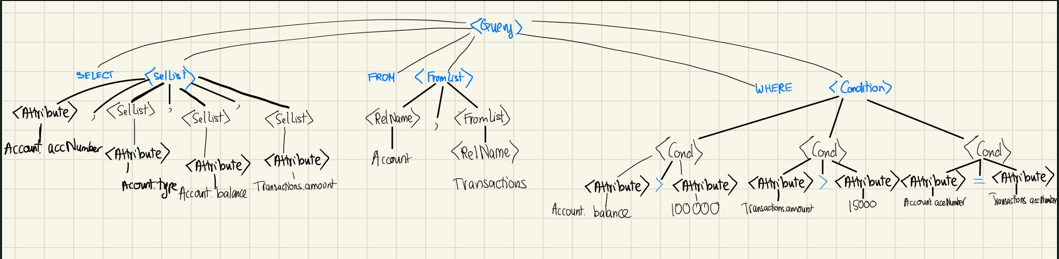

Q3.2. (3 points) Convert your parse tree to the equivalent relational algebraic representation (rewrite if necessary).

$\pi$$_{Account.accNumber, Account.type, Account.balance, Transactions.amount}$
($\sigma$$_{balance>100000}$(Account)$\bowtie$$\sigma$$_{amount>15000}$(Transactions)


##You may provide an image containing your answers for this question 

Q3.3. (3 points) Assume you have a million records in each of the six tables above. If you need, make necessary assumptions about your storage blocks, as well as about charactristics in the bank.db. Can you estimate the size and cost of the intermediate tables in your query plan?

Normal key: 20 byte, foreign key: 8 byte
Customer: 100 bytes 
Account: 68 bytes
Owns: 16 bytes (assuming 8 bytes per foreign key)
Transactions: 48 bytes (assuming 8 bytes for transNumber and 8 bytes for accNumberFK-Account, plus 4 bytes for amount)
Employee: 88 bytes
Branch: 68 bytes
Using these assumptions, estimate the size of the intermediate tables:

Size of Join Result (Account $\bowtie$ Transactions):

Account table: 68 bytes/record * 1 000 000 records = 68 000 000 bytes
Transactions table: 48 bytes/record * 1,000,000 records = 48 000 000 bytes
The join condition is on the accNumber attribute.
Assuming a B-tree index on accNumber for both tables, the cost of the join operation would be approximately the size of the smaller table (Transactions) plus the size of the index on the larger table (Account).
Size of Account index: 1 000 000 records * (4 bytes for pointer + 8 bytes for key) = 12 000 000 bytes
Total join result size ≈ 48 000 000 bytes (Transactions) + 12 000 000 bytes (Account index) = 50 000 000 bytes


Size of Filtered Result (Balance > 100 000):

Size of the filtered result would depend on the selectivity of the condition.
Assuming 50% of accounts larger than 100 000:
Filtered result size ≈ 50% * 20 000 000 bytes = 10 000 000 bytes


Size of Filtered Result (Amount > 15000):

Size of the filtered result would depend on the selectivity of the condition.
Assuming a 25% of the transactions larger than 15 000:
Filtered result size ≈ 25% * 20 000 000 bytes = 5 000 000 bytes


Size of Projection (Account.accNumber, Account.type, Account.balance, Transactions.amount):

Assuming each attribute is around 8 bytes long:
Size of each record ≈ 20 bytes * 4 attributes = 80 bytes
Total projected result size ≈ 32 bytes/record * number of records in the filtered join result
Overall Cost:
50 000 000 bytes + 10 000 000 bytes + 5 000 000 bytes + 80 bytes = 65 000 080 bytes

The overall cost would involve disk I/O, memory usage, and CPU processing, depending on factors such as indexing, caching mechanisms, and hardware specifications.

## Q4 (10 points) Normalization

Q4.1 (5 points) Find a lossless BCNF decomposition. Is it dependency-preserving?

Consider the schema over attributes A, B, C, D, E, F and the following set of FDs:

EF → BC 

A → D 

B → AE 

BD → C


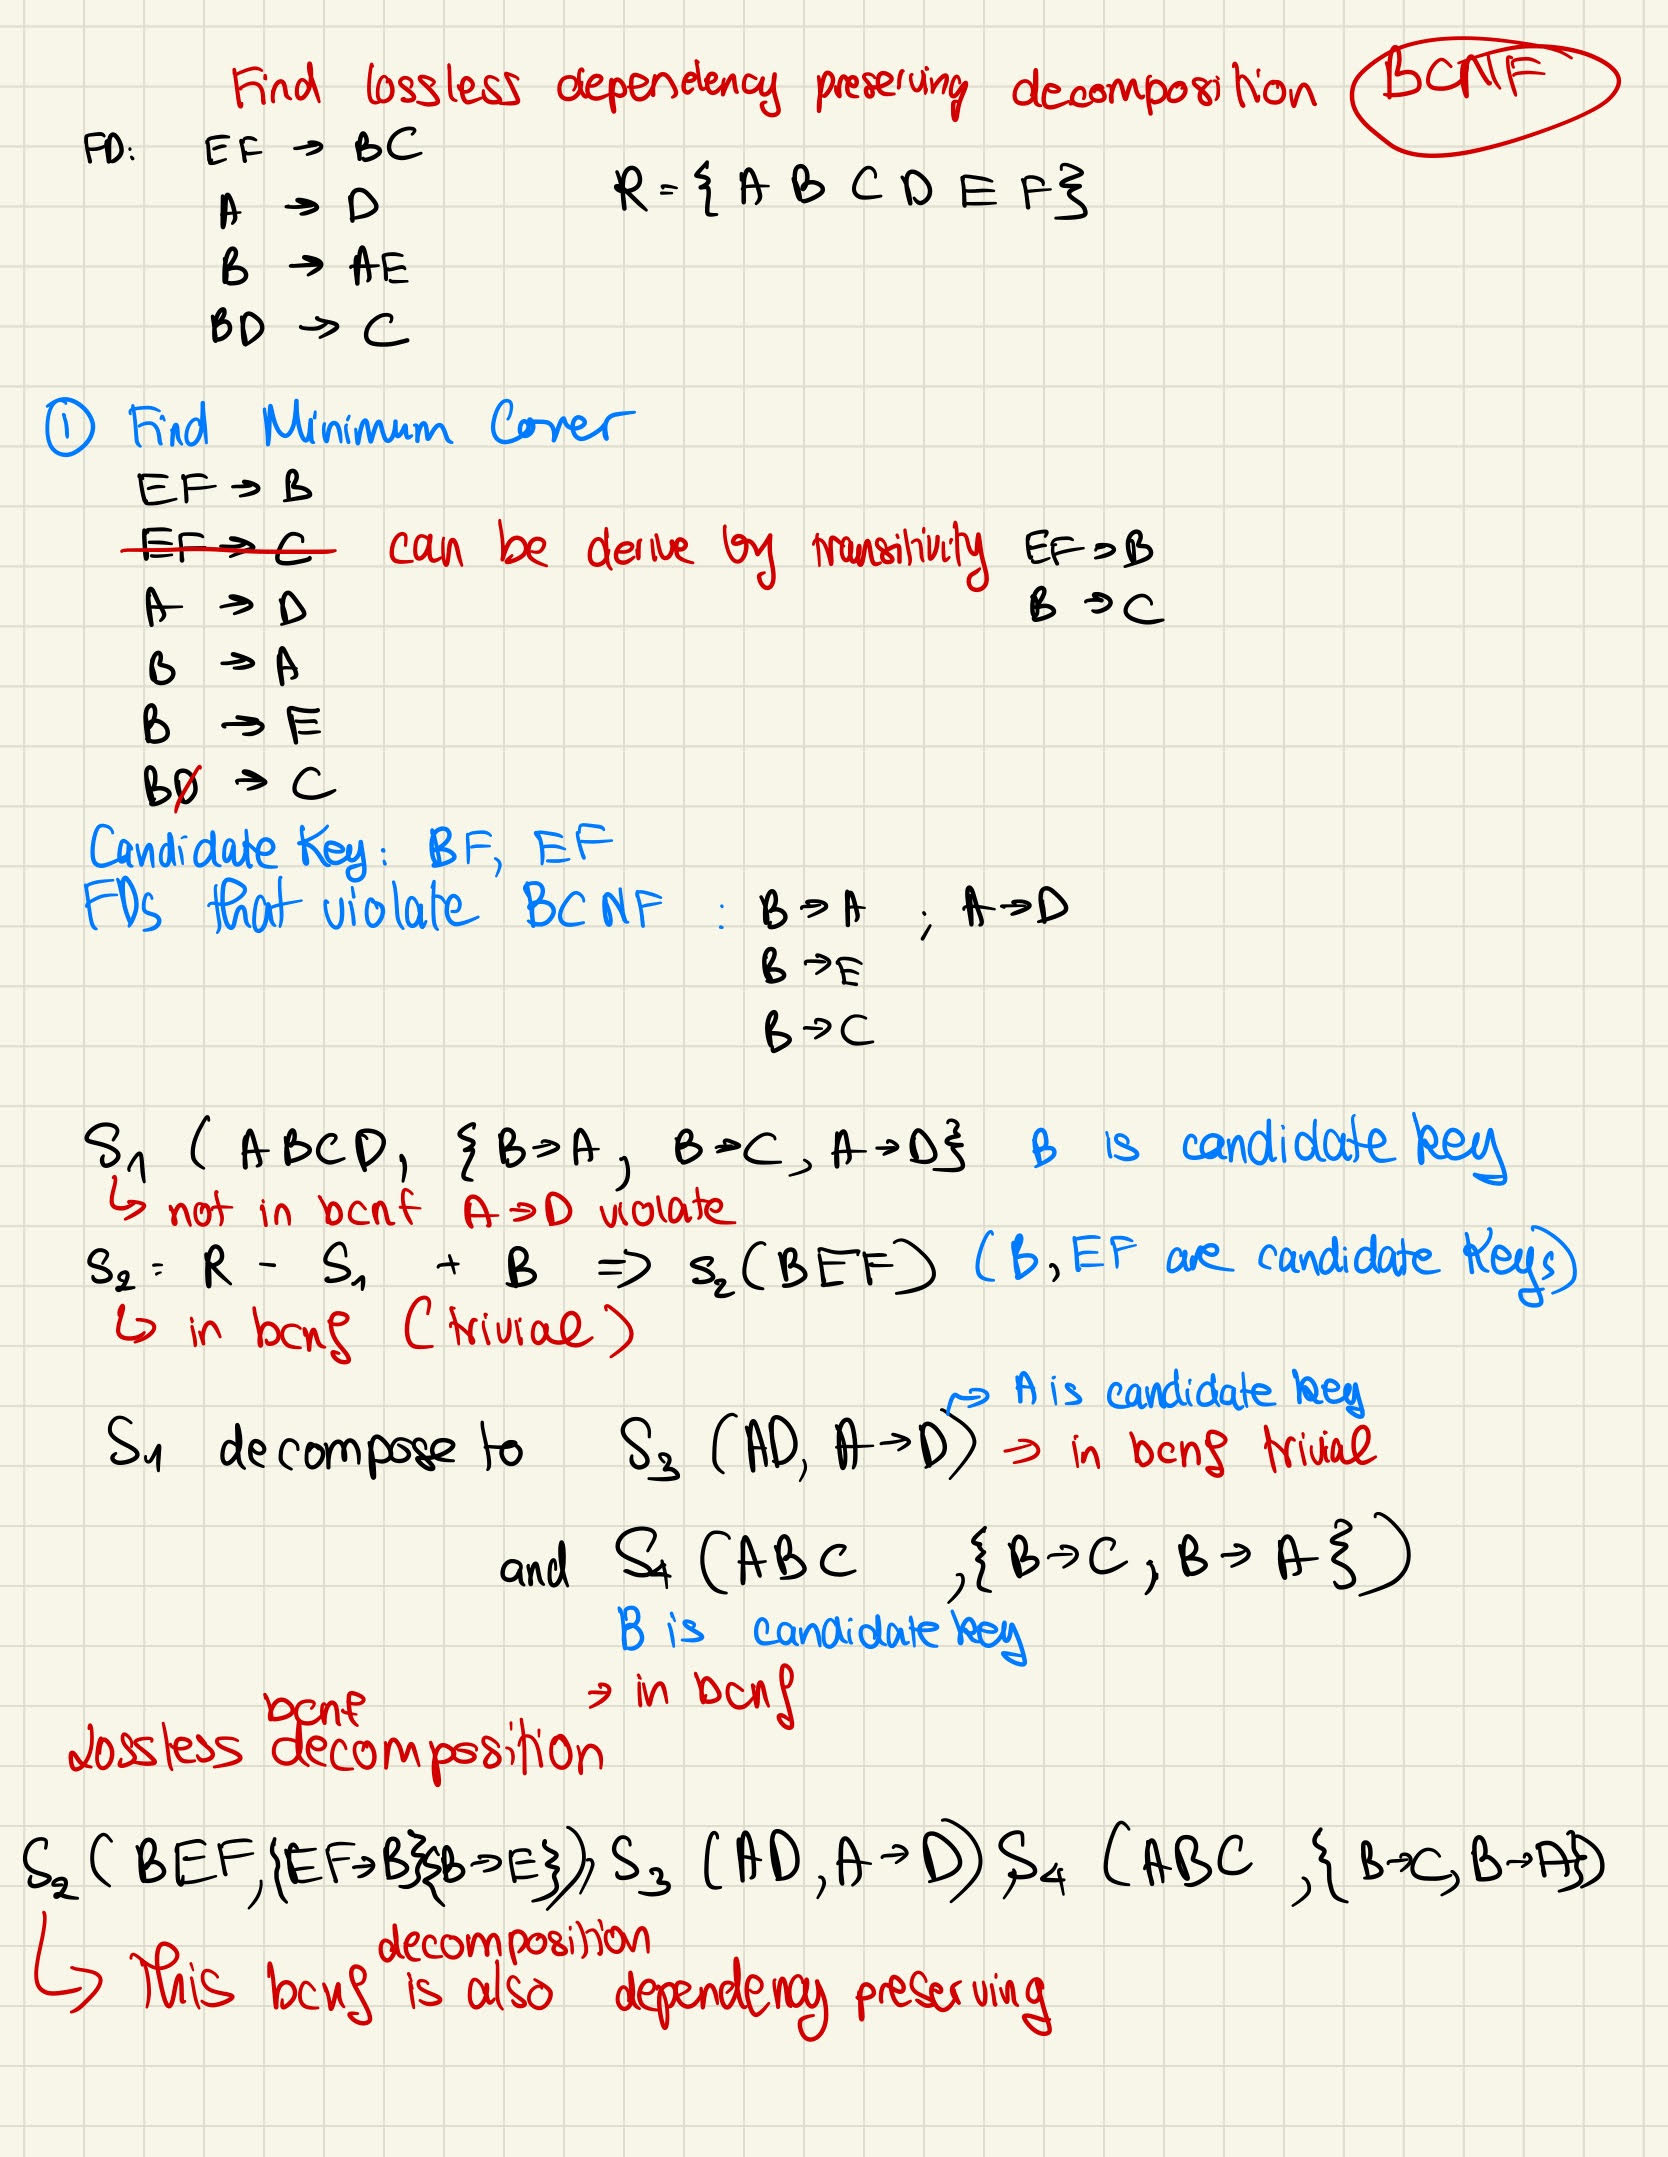

Q4.2 (5 points) Is the schema in 3NF? If not, apply the 3NF synthesis algorithm to obtain a lossless, dependency-
preserving 3NF decomposition.

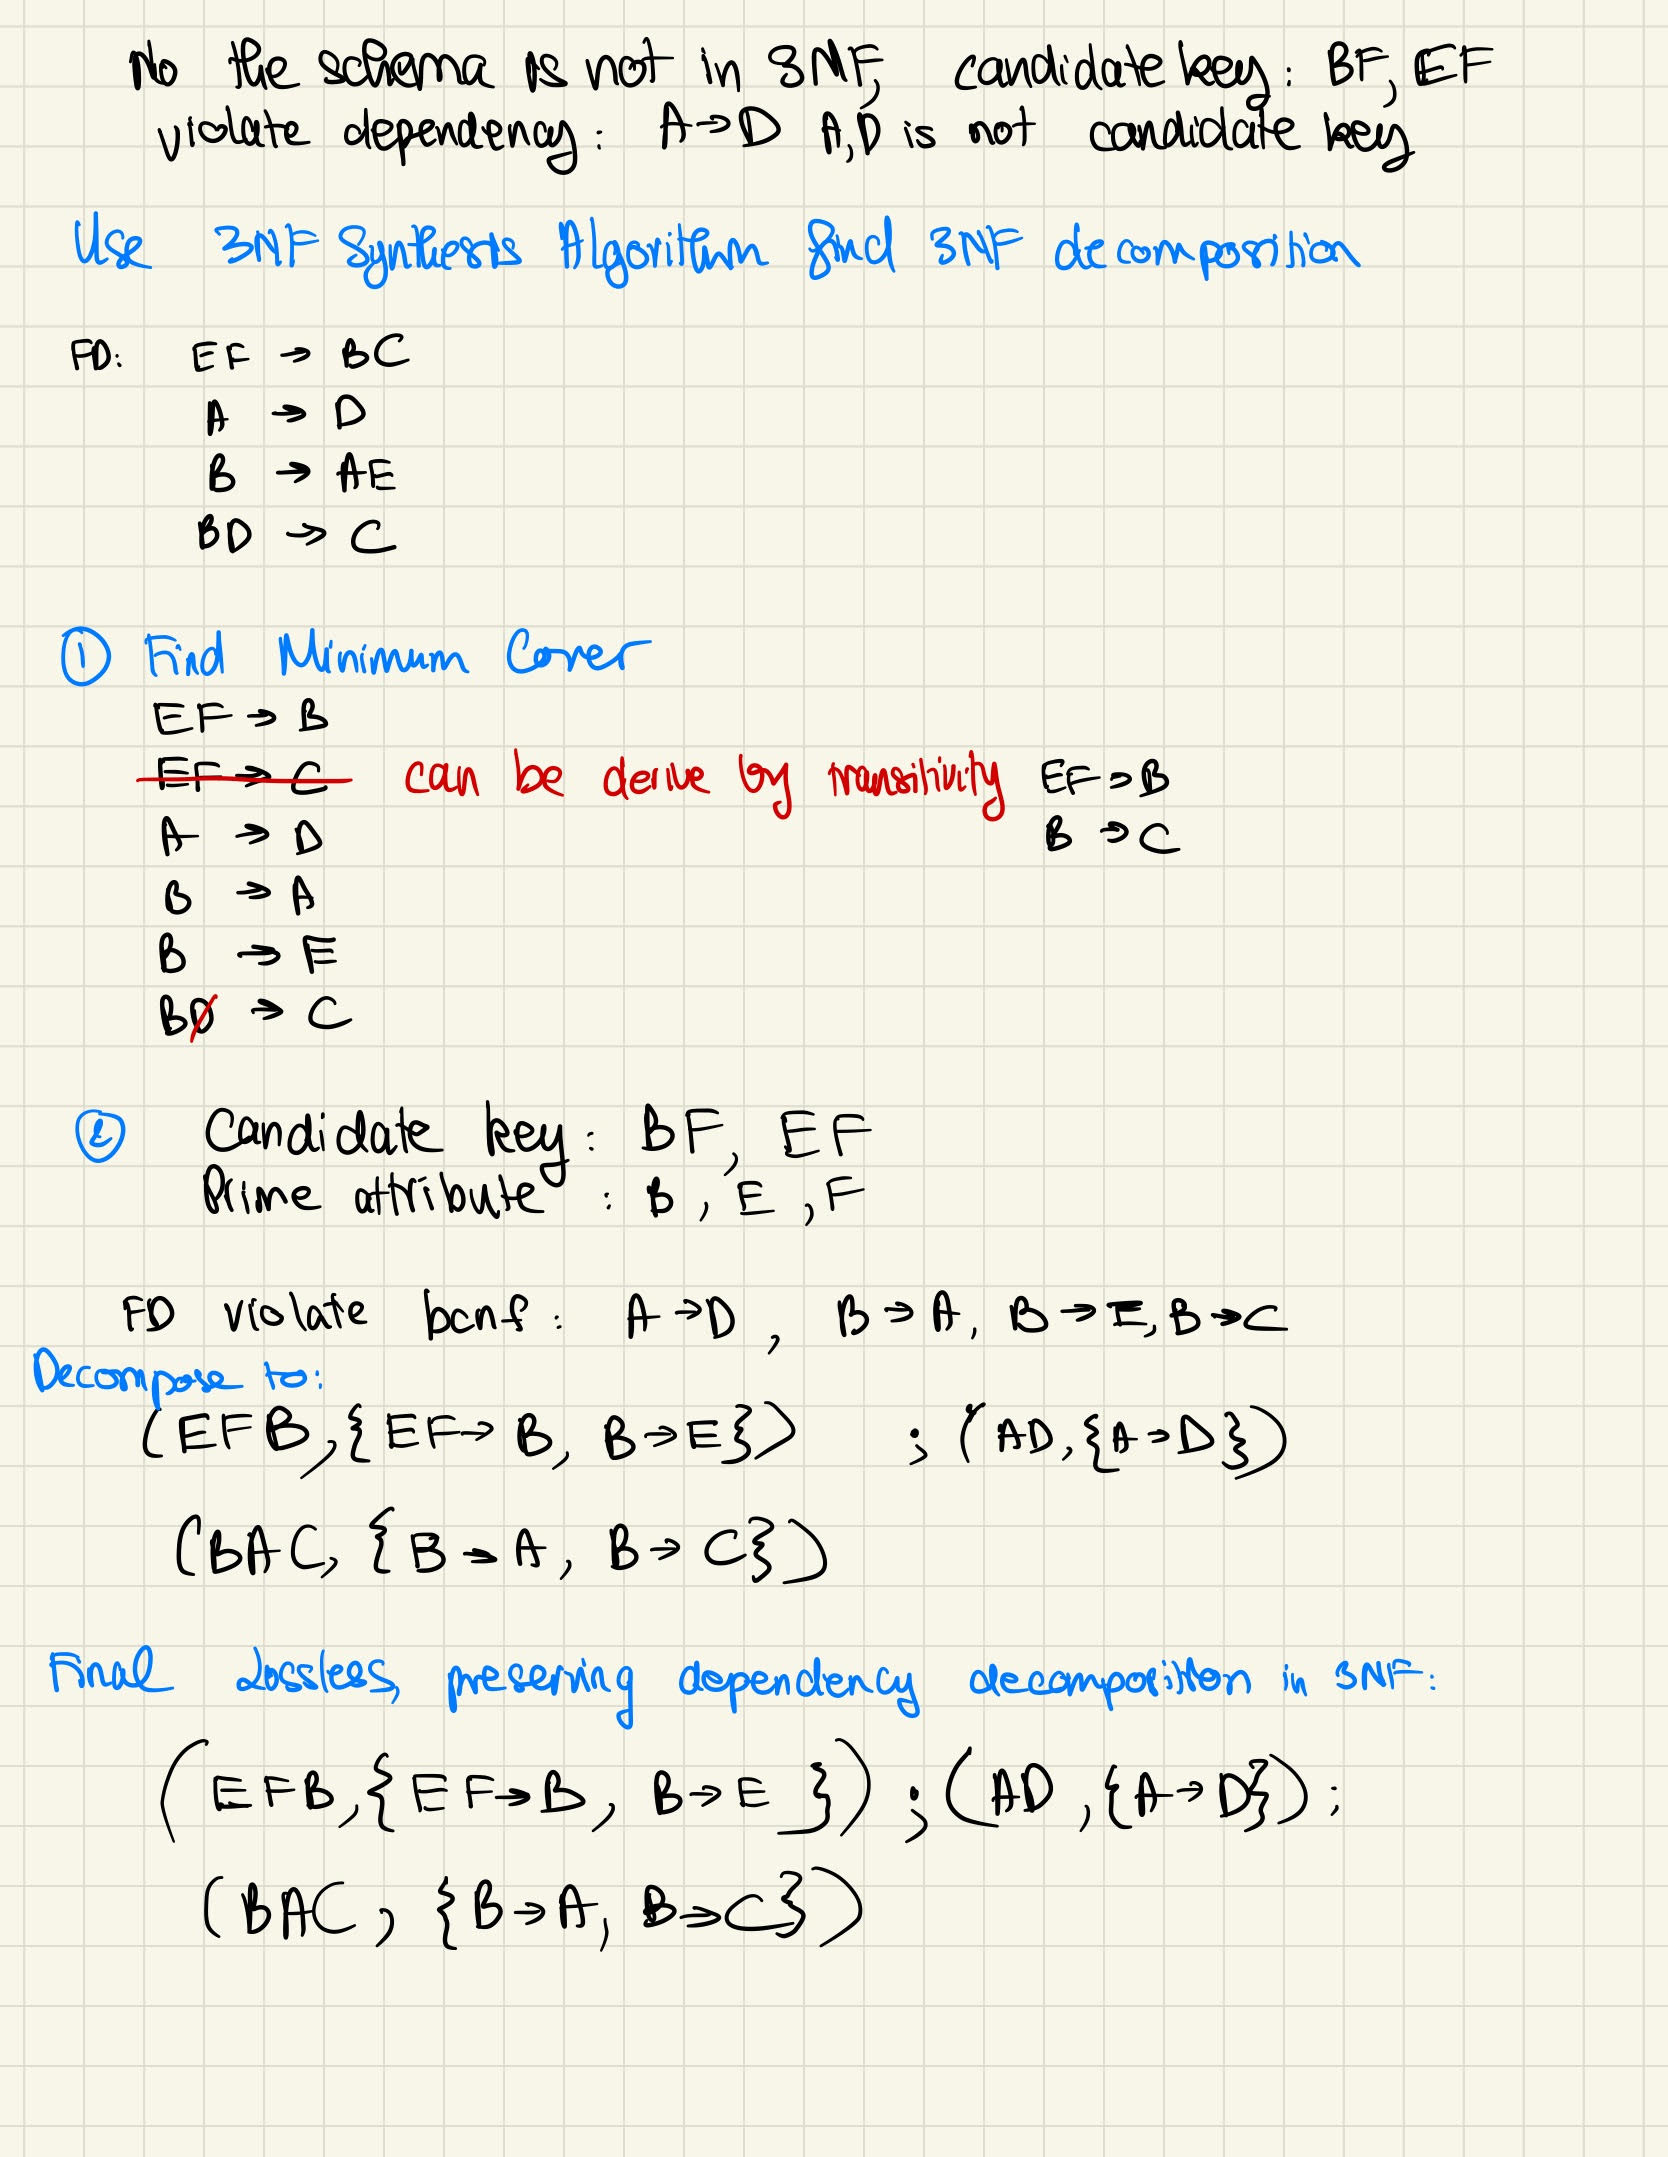

## Submission

Complete the answers to the questions in the [hw4.ipynb](hw4.ipynb) notebook and zip the notebook with additional image files that you may have used in a file named HW4.zip, and submit it through Canvas system to your Homework (4) activity.